In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import conll2000, stopwords
from nltk.stem import WordNetLemmatizer 

import warnings
warnings.filterwarnings("ignore")

In [2]:
def clean(text):
    cleaned=[]
    tok=nltk.RegexpTokenizer(r'\w+').tokenize(text=text)
    for w in range(len(tok)):
        tok[w]=tok[w].lower()
        if tok[w] not in stopwords.words('english'):
            cleaned.append(WordNetLemmatizer().lemmatize(tok[w]))
    return(' '.join(cleaned))

def TF(word, document):
    occ=document.count(word)
    return occ/len(document)

In [3]:
B=nx.read_adjlist('full_net.gz',  create_using=nx.DiGraph())
degs=B.out_degree()

In [4]:
#open comments from saved pkl
comments=pd.read_pickle("Comments_df.pkl")

In [27]:
data=pd.read_csv('statistiche.csv', encoding = "ISO-8859-1")
data=data.drop(['Unnamed: 0', 'favorite_count'], axis=1)

In [5]:
#select the nodes we want to study
keep=[x for x in B.nodes() if degs[x]>146]

#create a new df where the user channels appears in the one with the conditions stated in 'keep'
queryDF=comments.loc[comments.user_channel_id.isin(keep)]

B1 = nx.DiGraph()
#add nodes of bipartite graph from users and videos
B1.add_nodes_from(queryDF['user_channel_id'], bipartite=0)
B1.add_nodes_from(queryDF['video_id'], bipartite=1)
#add edges
B1.add_edges_from([(row['user_channel_id'], row['video_id']) for idx, row in queryDF.iterrows()])
#set position for the plot
pos = {node:[0, i] for i,node in enumerate(queryDF['user_channel_id'])}
pos.update({node:[1, i] for i,node in enumerate(queryDF['video_id'])})

In [6]:
B1degree=B1.out_degree()
users=[x for x in B1.nodes() if B1degree[x]>=1]
videos=[x for x in B1.nodes() if B1degree[x]==0]

In [7]:
B1=nx.to_undirected(B1)

In [8]:
user_projection=nx.bipartite.weighted_projected_graph(B1, users, ratio=True)
video_projection=nx.bipartite.weighted_projected_graph(B1,videos, ratio=True)

In [9]:
print('number of users ' + str(len(users)))
print('number of videos ' + str(len(videos)))
print('number of edge in the graph '+ str(B1.number_of_edges()))

number of users 561
number of videos 7872
number of edge in the graph 110683


C:\Users\giuli\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


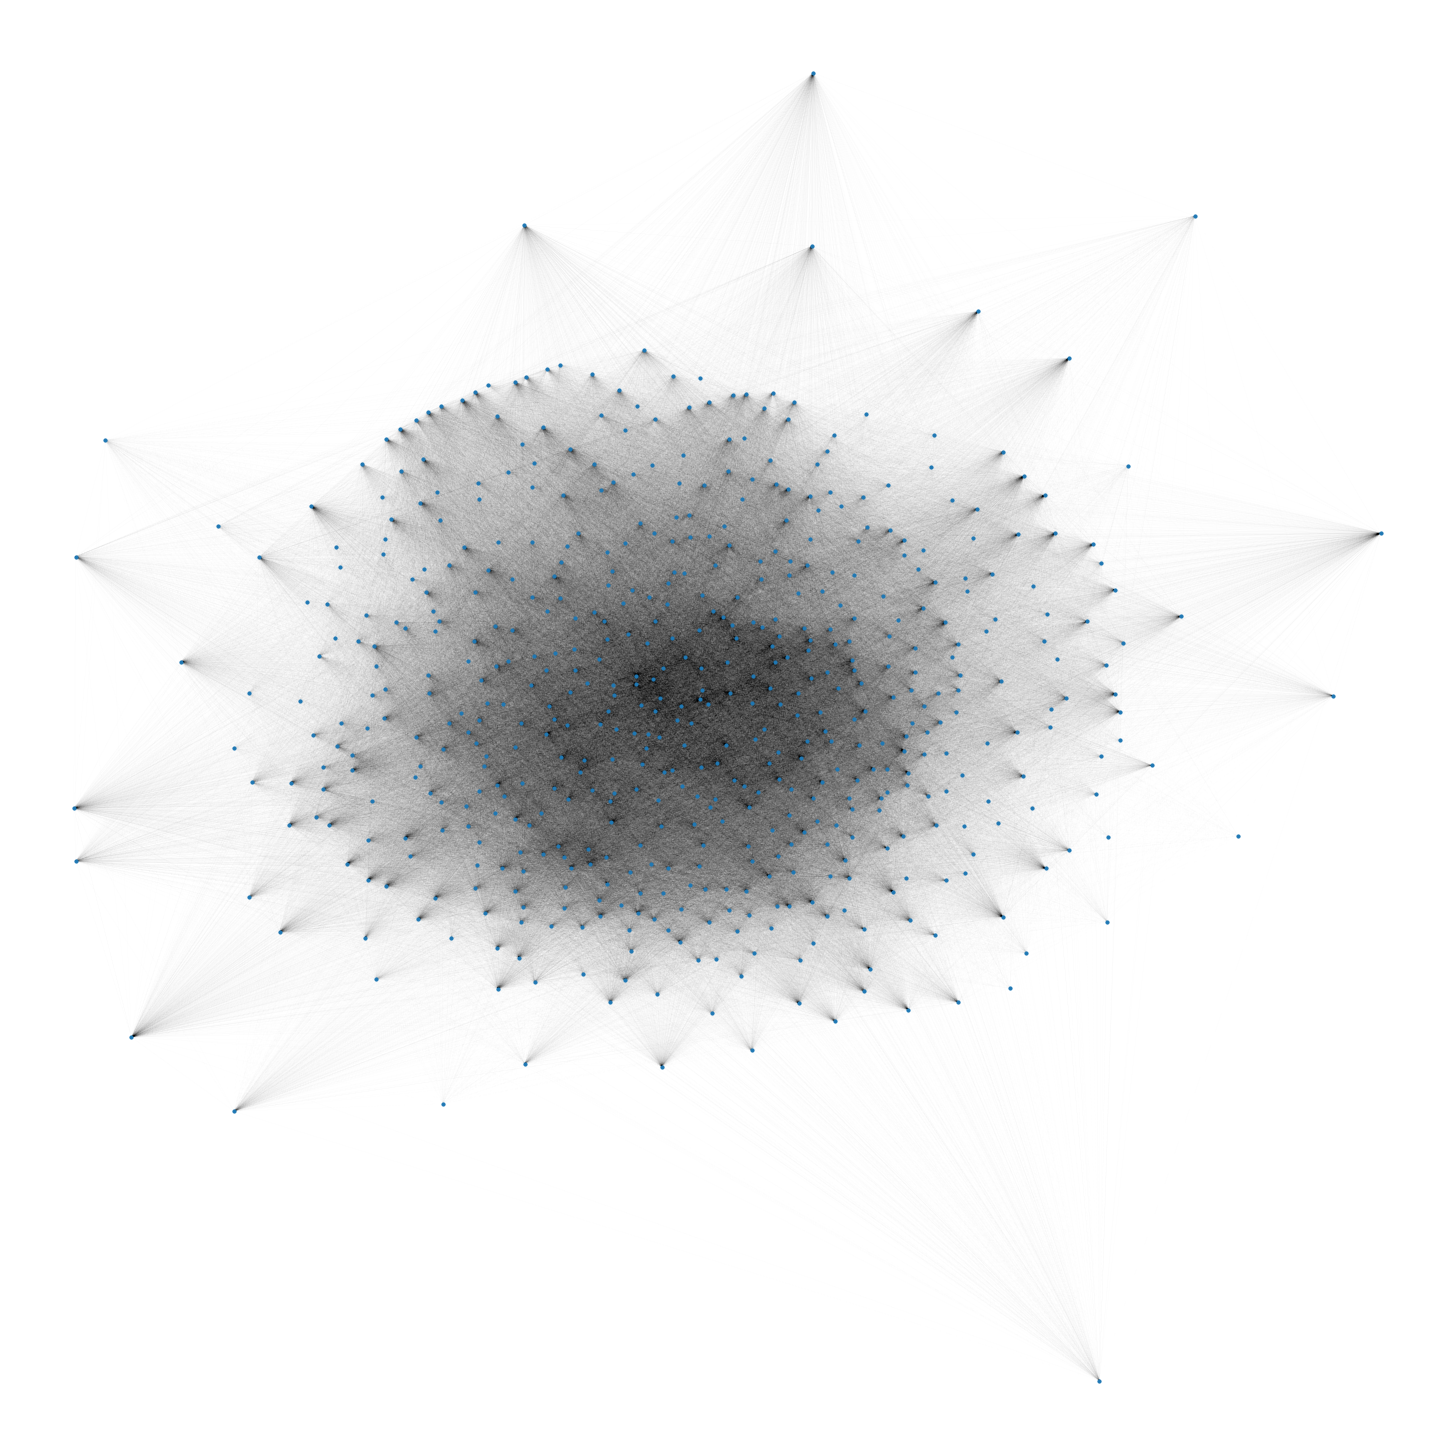

In [109]:
pos = nx.kamada_kawai_layout(user_projection)
edge_widths = [w for (*edge, w) in user_projection.edges.data('weight')]
plt.figure(figsize=(20,20))
nx.draw(user_projection, with_labels=False, node_size=10, width=edge_widths, pos=pos)
plt.show()

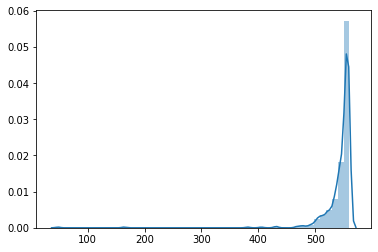

mean is 543.3083778966131
median is 552.0


In [41]:
"""sns.distplot(list(dict(user_projection.degree).values()))
plt.show()
print('mean is '+str(np.mean(list(dict(user_projection.degree).values()))))
print('median is '+str(np.median(list(dict(user_projection.degree).values()))))"""

In [9]:
user_weight=[w for w in list(zip(*user_projection.edges.data('weight')))[2]]

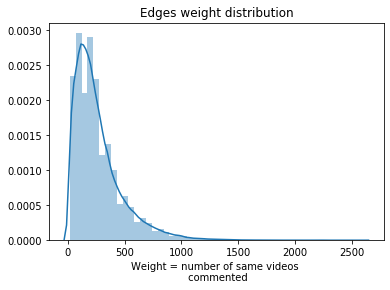

mean is 0.0017451413190984625
median is 0.0013973577235772358


In [10]:
sns.distplot(np.array(user_weight)*(user_projection.size()-1))
plt.title('Edges weight distribution')
plt.xlabel('Weight = number of same videos \n commented')
plt.show()
print('mean is '+str(np.mean(user_weight)))
print('median is '+str(np.median(user_weight)))

In [11]:
userq3=np.quantile(user_weight, q=.75)

In [12]:
top_users=[i[:1] for i in list(user_projection.edges.data('weight')) if i[2]>userq3]
top_users=list(np.unique(top_users))
top_users_comments=comments.loc[comments.user_channel_id.isin(top_users)].reset_index(drop=True)

In [13]:
corpus=[]
for user in top_users:
    his_comm=top_users_comments.loc[top_users_comments.user_channel_id==user]
    his_list=[]
    for i in his_comm.index: 
        temp=(his_comm.comment_text_original[i])
        his_list.append(temp)
    corpus.append(''.join(his_list))

In [14]:
cleand=[]
#for each user in the corpus
for user in range(len(corpus)):
    his_clean=[]
    #tokenize the text of this user and create a list of words
    tok=nltk.RegexpTokenizer(r'\w+').tokenize(text=corpus[user])
    for w in range(len(tok)):
        #for each word, make it lower
        tok[w]=tok[w].lower()
        #check if stopword
        if tok[w] not in stopwords.words('english'):
            his_clean.append(WordNetLemmatizer().lemmatize(tok[w]))
    cleand.append(his_clean)

In [15]:
#join all cleaned text together to get to a cleaned corpus
cleaned_corpus=[]
for i in cleand:
    cleaned_corpus.append(' '.join(i))

In [16]:
#create tfifd matrix
vect = TfidfVectorizer(min_df=1, stop_words="english")
tfidf = vect.fit_transform(cleaned_corpus)
#compute pairwise similarity
pairwise_similarity = tfidf * tfidf.T

#get into a matrix
simmat=pairwise_similarity.A
#fill diagonal with 0
np.fill_diagonal(simmat, 0)

In [17]:
"""plt.figure(figsize=(10,10))
plt.xlim(-0.05,1.05)
for i in range(len(simmat)):
    sns.distplot(simmat[i], hist=False)
plt.show()"""

'plt.figure(figsize=(10,10))\nplt.xlim(-0.05,1.05)\nfor i in range(len(simmat)):\n    sns.distplot(simmat[i], hist=False)\nplt.show()'

In [18]:
random_users=pd.DataFrame(comments.user_channel_id.unique()).sample(n=len(top_users), random_state=42)[0]
random_sample=comments.loc[comments.user_channel_id.isin(random_users)].reset_index(drop=True)

In [19]:
random_corpus=[]
for user in random_users:
    his_comm=random_sample.loc[random_sample.user_channel_id==user]
    his_list=[]
    for i in his_comm.index: 
        temp=(his_comm.comment_text_original[i])
        his_list.append(temp)
    random_corpus.append(''.join(his_list))

In [20]:
clean_random_corpus=[]
for i in range(len(random_corpus)):
    clean_random_corpus.append(clean(random_corpus[i]))

In [21]:
tfidf = vect.fit_transform(clean_random_corpus)
#compute pairwise similarity
pairwise_similarity = tfidf * tfidf.T

#get into a matrix
rand_simmat=pairwise_similarity.A
#fill diagonal with 0
np.fill_diagonal(rand_simmat, 0)

In [22]:
"""plt.figure(figsize=(10,10))
plt.xlim(-0.05,1.05)
for i in range(len(rand_simmat)):
    sns.distplot(rand_simmat[i],  hist=False)
plt.show()"""

'plt.figure(figsize=(10,10))\nplt.xlim(-0.05,1.05)\nfor i in range(len(rand_simmat)):\n    sns.distplot(rand_simmat[i],  hist=False)\nplt.show()'

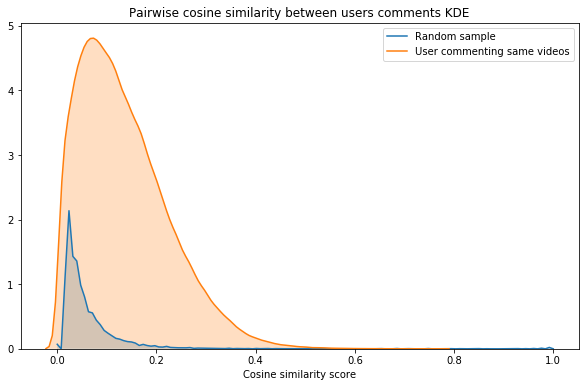

In [23]:
plt.figure(figsize=(10,6))
sns.distplot(rand_simmat.reshape(-1,1), kde_kws={"shade": True}, hist=False, label='Random sample')
sns.distplot(simmat.reshape(-1,1), kde_kws={"shade": True}, hist=False, label='User commenting same videos')
plt.title('Pairwise cosine similarity between users comments KDE')
plt.xlabel('Cosine similarity score')
plt.legend()
plt.show()

In [123]:
len(top_users_comments.comment_id.unique())

170975

### Videos

In [24]:
video_weight=[w for w in list(zip(*video_projection.edges.data('weight')))[2]]

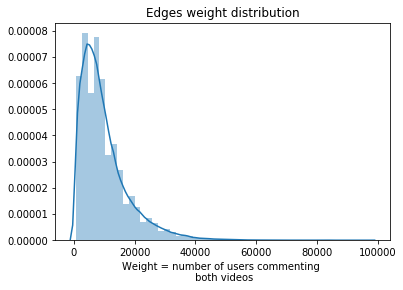

mean is 0.003679735283138524
median is 0.0017825311942959


In [25]:
sns.distplot(np.array(user_weight)*(video_projection.size()-1))
plt.title('Edges weight distribution')
plt.xlabel('Weight = number of users commenting \n both videos')
plt.show()
print('mean is '+str(np.mean(video_weight)))
print('median is '+str(np.median(video_weight)))

In [26]:
videoq3=np.quantile(video_weight, q=.75)

In [28]:
top_videos=[i[:1] for i in list(video_projection.edges.data('weight')) if i[2]>videoq3]
top_videos=list(np.unique(top_videos))
top_videos_titles=data.loc[data.video_id.isin(top_videos)].reset_index(drop=True)

In [42]:
vid_corpus=[]
for video in top_videos:
    vid_corpus.append(top_videos_titles.loc[top_videos_titles.video_id==video].reset_index().title[0])

In [44]:
clean_vid_corpus=[]
for i in range(len(vid_corpus)):
    clean_vid_corpus.append(clean(vid_corpus[i]))

In [47]:
tfidf = vect.fit_transform(clean_vid_corpus).A

In [59]:
for i in range(len(tfidf)):
    print(f'video {top_videos[i]} represented by word {vect.get_feature_names()[tfidf[i].argmax()]}')

video --4GVsUJFbw represented by word 18
video --nN7k0Rc9U represented by word persuade
video -3ywUSXFcGQ represented by word 13
video -42A0q4QKjg represented by word finding
video -8ClCYNIEGc represented by word snow
video -8pNPyG3MmA represented by word told
video -A6dyHA2KMM represented by word critical
video -ASCNZRnDwk represented by word elevator
video -B5YCQamLes represented by word teach
video -BJbnFg2i70 represented by word happens
video -EQy2eawqS0 represented by word weapon
video -EW19XZiUuw represented by word offered
video -FsA-MblKI0 represented by word firm
video -G3wVnR_2vQ represented by word sharp
video -J8wdqO1_UQ represented by word enter
video -JFC81JEoIw represented by word originated
video -JKAjHOltes represented by word 18
video -L5nyQ5kf54 represented by word closed
video -LKVUarhtvE represented by word soap
video -LR07LmcywE represented by word knowledge
video -LqWX8D_Tns represented by word joke
video -M3CSea6lYc represented by word known
video -OdWMu_6jMg re

video 26UeqtATRp0 represented by word soul
video 26zSHaMFt-E represented by word health
video 271Gmv53dTw represented by word bringing
video 275me_hVRhg represented by word pace
video 28ZN0wsfBpk represented by word cope
video 28skzHX8nUs represented by word stop
video 2B-rYVWmqoI represented by word ho
video 2BKRvBNy2R0 represented by word level
video 2DZYnBvVdLY represented by word progressive
video 2DekzGCJhJw represented by word lethal
video 2DsVhaXx8_I represented by word think
video 2F3KHb_1bkw represented by word ignore
video 2FfPXjzMyFs represented by word italy
video 2GvGoqSGGvE represented by word failing
video 2H-8zWi5kBc represented by word urge
video 2HFEDWkY_2I represented by word bbc
video 2HGOBNJlCAk represented by word selling
video 2HbF0LnEWtI represented by word learn
video 2IUeuS3Qaes represented by word healthy
video 2IjwAvQ-8nc represented by word reopening
video 2J4ddPVcq4Q represented by word chen
video 2JsWf-2nN1Y represented by word happens
video 2KWBG2ItgOY r

video 5XYstLankUs represented by word powell
video 5XmjPIMo3js represented by word speaks
video 5XzPkTd0eos represented by word ignoring
video 5Y7qcAOpw8o represented by word going
video 5YcnVYW6p5s represented by word spying
video 5YiBZp2JXXI represented by word movie
video 5YrZCmDDfZw represented by word shown
video 5ZHXFirbc4k represented by word spot
video 5Zr7koliBUk represented by word p4
video 5_DoQK7CDq0 represented by word appreciates
video 5_GXf-coAXc represented by word documenting
video 5_UZpS6Xht4 represented by word urged
video 5b5Ed5mJ8RI represented by word inevitable
video 5c3wWNsmLA0 represented by word questioned
video 5dG84NorweE represented by word 000
video 5fTSrArRp8M represented by word chief
video 5fhQoH7PsIk represented by word backlash
video 5h7ulAg3_Ls represented by word 17
video 5hOBB0ZrAOE represented by word unknown
video 5i0eoCEzdQ0 represented by word recorded
video 5iJ1pqq8Ln8 represented by word criticise
video 5km1gG1PeFY represented by word bay
vid

video 8lPrLPKsOy4 represented by word secure
video 8mWxH6Bu52I represented by word antarctica
video 8nuRZwQsLf0 represented by word lakshmi
video 8opSfaCD5iE represented by word batwoman
video 8pecWngCcQ8 represented by word president
video 8qXzP1Ckb1k represented by word neighbourhood
video 8seNGA1pJ_Y represented by word indonesian
video 8uIVf_o9aXM represented by word describes
video 8v3hKO6Jm2w represented by word cosmos
video 8vxcaWW2KXI represented by word democrat
video 8w61tigk0ag represented by word view
video 8y52PsZOSg8 represented by word capital
video 8yU-9SQoS6I represented by word senate
video 9-8eB-b9jJ0 represented by word bavaria
video 91PvosqXUFU represented by word europe
video 93TpfCzpM3Y represented by word treat
video 94Bzy06s3Tc represented by word impose
video 95eNDcugOYU represented by word approved
video 9619qaAjLq4 represented by word celebs
video 9654d4dwVmw represented by word blue
video 96mGu-Xmjjo represented by word federal
video 96xAA742do8 represented

video BWO6i8cH8SA represented by word blooper
video BWb8YqAVTgw represented by word timeline
video BWz9cz6BIhI represented by word ccp
video BZBfWc5VAXQ represented by word 9th
video B_-rbv0tp2k represented by word sale
video Bb4BlkOhlXs represented by word sat
video BcZ5n_257sI represented by word race
video BcbdW8bsKDY represented by word advisory
video Bf3XS2kLOJQ represented by word contact
video BfKA-_V5NKw represented by word processing
video Bga_qG30JyY represented by word dose
video BhmCpk5SO6Q represented by word crash
video Bi2gqvaTeXw represented by word jennifer
video BiGWVklFFDw represented by word reacting
video BiWnOATjtcc represented by word disappear
video BkZI-IzwPnY represented by word boot
video BkbztWS4-9I represented by word newsnight
video BnGypKlAWko represented by word opts
video BofuedKt5_E represented by word bianco
video Bpt8qJsNkQE represented by word competence
video BqLXmnFqNNY represented by word 850
video BrDc6KpW1uo represented by word economic
video B

video EBXzjBHx1_w represented by word 37
video ECOQVFgeC6o represented by word make
video EDM3FvkICaM represented by word lead
video EDfbYEqCCHU represented by word investor
video EFRwnhfWXxo represented by word 46
video EFsQjpOWH-g represented by word chance
video EI4H81pPCKU represented by word coordinated
video EIIgIKMgUIQ represented by word magic
video EJDYz2Cd9dE represented by word sharp
video EK4dbeEYpgE represented by word 28
video EK7QbQhqddY represented by word industrial
video EL9qOUAR6fA represented by word overtime
video ELMd5SUqDMI represented by word oil
video ELOZ6fU20Sk represented by word hoax
video ELPnVZuQvFI represented by word scared
video ELYoQtSdVnE represented by word 130
video EMelkdO7JL0 represented by word college
video EMim8cu708Q represented by word commissioner
video ENKIYjrEY3w represented by word journey
video EOcahxnQsak represented by word hearse
video EPCqPwXKzKQ represented by word shop
video EPf5YqFWgbI represented by word double
video EQ7DhRt7GSk

video GzSltiokD4k represented by word animal
video GzgsLd9mU4o represented by word announced
video H0yronxKXak represented by word easy
video H1A4QsER1TI represented by word legislator
video H1HtlagxDMU represented by word oliver
video H1LHgyfPPQ8 represented by word 47
video H1M6wqRKO74 represented by word battling
video H4e7A60DBPo represented by word golf
video H4oyiVLG3ZI represented by word negative
video H86aF-n4uQ8 represented by word forgiveness
video HA7sP47e8tA represented by word liner
video HAKrSNDQuOU represented by word preparedness
video HAnmjEDmzk4 represented by word corrects
video HFbtShY2R1I represented by word 145
video HIVS1_IbUgY represented by word destroy
video HImj__5VoiM represented by word esquire
video HJ2Ec7pgQiQ represented by word impacted
video HKhu0_jrVDU represented by word nearly
video HL3TpRQ-oa4 represented by word emerge
video HLaSwerPrDI represented by word breakthrough
video HLtwnUJteGU represented by word sending
video HMCQwgHMXHw represented by

video KJynvTWFlf8 represented by word far
video KK6lWBqvayk represented by word huge
video KKRwAE0yJl0 represented by word resolved
video KLPx3BcyG4c represented by word locking
video KN3HWgyXe1U represented by word disembark
video KP6ru9aE8OM represented by word combating
video KPSBqJOTWuk represented by word dark
video KQut0ABMBPQ represented by word disappears
video KRvorrGmYfY represented by word warehouse
video KRx1Rg6AChY represented by word wion
video KTGEf1u-wVc represented by word short
video KUDLkJ1w7vE represented by word aid
video KV_4nKTy1yo represented by word nanshan
video KWd-Tkcrnkc represented by word trigger
video KXL6HoBIsAo represented by word conference
video KXLPJrtRI8M represented by word practice
video KZ6hmybH6-8 represented by word far
video KZIt1XhU2RI represented by word medium
video KZhBy64bimc represented by word spreader
video Ka-9b3ih7D4 represented by word 16
video Ka48UZDDzLY represented by word severity
video KaUqImMvaVQ represented by word beijing
v

video NcSUF8erpfU represented by word craziest
video NccmaDuCAcw represented by word africa
video Nd1Qkdt4L2c represented by word hydroxychloroquine
video NdiaHiIt3II represented by word soar
video NeDeOxb4ofg represented by word health
video Neayu93BH6Q represented by word garcetti
video NetMJvhcHHo represented by word specialist
video NezEbDx4B9A represented by word tune
video NfZcH8LA8pc represented by word shortcoming
video Nhp4vL1LgAA represented by word close
video NiQKvfo3l94 represented by word bunch
video NicMtHXauZM represented by word heightens
video Niw6tk1sB8M represented by word 20
video NjE8cgRhFf0 represented by word maximum
video Nk5P_iRYwTY represented by word told
video Nk7Z9C7eyic represented by word cough
video NkHtQP36f08 represented by word 2000
video NkN8yCWSGus represented by word beat
video NlI4UvDDcJI represented by word unnecessary
video NloOWphI5bw represented by word corner
video NmaTkIdUxjE represented by word king
video Nmrm0mk5928 represented by word de

video RMYQjqiCSHM represented by word capture
video ROnAfAeoceY represented by word manipulates
video RP4CqeNOhHA represented by word easter
video RP_lx9N8xQg represented by word blow
video RQ7RWkY0QlU represented by word severe
video RR2JfKjl3Gg represented by word ally
video RR4_DKb55S4 represented by word spokesman
video RSiW6ZvPqeg represented by word honest
video RStW_E3IBYk represented by word surrounding
video RTbJ2wKILJM represented by word like
video RUA_XxghA3I represented by word vaccine
video RUJ97CuVUHY represented by word equipment
video RUZQA0z2SbE represented by word rescue
video RVSuz1gJkZg represented by word street
video RX9r5ORKdp0 represented by word illness
video RXGmX2-m348 represented by word normal
video RYr_Z-Dmp_k represented by word describes
video R_o624hesB4 represented by word podcast
video Rb32Fv-MX80 represented by word servitude
video RbJYRDo62tc represented by word 919
video RbQjqSvL1YE represented by word quick
video Rd6vycI1l-k represented by word p

video UcxHL8LHI_A represented by word prepare
video Ug1ZIHkxT8g represented by word restrict
video UibwTfjTA_0 represented by word aboard
video UjazIkK36-k represented by word 755
video Uk5gw0uSpsA represented by word foothold
video Uk_S_eE0hMs represented by word 300
video UkcFxpbFlaI represented by word coordination
video UlCYFh8U2xM represented by word dodge
video UlkauW3Sxyw represented by word surprised
video UlpnrBGgd84 represented by word deciding
video UmF3v2Cze9s represented by word kill
video UmFEWnNH1ug represented by word saying
video UmWNR9zXrls represented by word meet
video Un-DdiDJFns represented by word identity
video UnSILVWDKL8 represented by word oan
video Uo8WQ_5_uH0 represented by word reportedly
video UoDyLwSxFis represented by word prepper
video UoErujrHgAI represented by word heart
video UoxxzO47kgA represented by word consistent
video Up-vlqHdCqc represented by word iraq
video UqNjzTz0w68 represented by word vulnerable
video Ut1BCR1fzv0 represented by word dep

video X7KCyRxOoJw represented by word starting
video X7P66I4p5LQ represented by word 0001f525
video X7lHhGXM0Uo represented by word surpasses
video X8DjXOJNUlg represented by word chat
video X8Rpwe0d40A represented by word belief
video X9RKReLDjbM represented by word harald
video X9mxpkPEy0Y represented by word shoot
video XB-ZQpC42EQ represented by word unemployment
video XBYnlCE_l6M represented by word fighter
video XBquSrErhps represented by word postponed
video XDAbEWrvYqY represented by word hear
video XDxaaNPw8es represented by word 900
video XESb2saJj2E represented by word warning
video XFNt4RL192Y represented by word inform
video XFYGM9sQQvo represented by word gradual
video XH8OqojDvCA represented by word related
video XHOam63sLZc represented by word harbor
video XHsfjnRB-uA represented by word guayaquil
video XJU-4kQr_6o represented by word 79
video XJV3X8zM1bU represented by word declaration
video XKDLg-YVyIg represented by word tuesday
video XKQcst4obkQ represented by word 

video ZWn-K2sBo-8 represented by word 58eb
video ZXGmQWvvwA0 represented by word tone
video ZXOEoLSMrYs represented by word andrew
video ZY46G0dpgSA represented by word stage
video ZYsy3bvxeCY represented by word clamp
video Z_8LnnHMeG4 represented by word blower
video Z_R78v-aflM represented by word changing
video Zabxwzq_wfA represented by word 3rd
video ZavfBN9Uba8 represented by word worried
video ZbXHIYBrFss represented by word extreme
video Zcw29KHJkt0 represented by word remdesivir
video ZdaIudGpDFI represented by word 0001f30d
video Ze2qyzVS3rc represented by word medic
video Zed4WQKbHOU represented by word 500
video ZemaOxVpN34 represented by word transparency
video Zg0fajVvQ5c represented by word raised
video Zgn_XoQWZhw represented by word forbes
video Zh3YBVjDXfY represented by word milan
video ZhNOuDYKkzM represented by word conference
video ZhfHZa5MvBY represented by word antiviral
video ZhyT4POuRN4 represented by word verge
video Zk4L0kXL0tE represented by word vice
vide

video bCnT2owc1Z8 represented by word epstein
video bCwj3yMLz30 represented by word unlikely
video bDAjoaw6rHg represented by word stayed
video bDKsZnG6r1A represented by word controversial
video bE68xVXf8Kw represented by word battling
video bGKX0twspvE represented by word thursday
video bHOPzFHncpU represented by word buy
video bIFmh5ujKRw represented by word europe
video bIyYq4u0YPo represented by word big
video bKf4fJlPjiU represented by word approved
video bL54LgOlqlw represented by word friday
video bLfriUWYlQE represented by word documentary
video bLr09SVhqsQ represented by word explaining
video bLuNg677AqA represented by word sacramento
video bMNk8Wir1j0 represented by word traveller
video bNfxqVOBL8c represented by word 2003
video bNpBoNeGtoA represented by word le
video bOE4b2KxM8E represented by word cow
video bOGO2S5FOTc represented by word escalation
video bOKxszLpYHk represented by word moh
video bQI31NICnw0 represented by word citi
video bR-ZnBjMo_U represented by word e

video eLgbpnILYyQ represented by word reckoning
video eMyLs7W_eLc represented by word exceeds
video eNt0s3uZEl0 represented by word 185
video eNxjsD80LHs represented by word skyrocket
video eOB-z-g9v74 represented by word negative
video eQJteHRyclI represented by word lasted
video eRa_hi63iVQ represented by word family
video eRlqgDRS-OQ represented by word nervous
video eSWiBWUoeSk represented by word queen
video eUPkZJRyVps represented by word understand
video eVXfymnT9i8 represented by word lie
video eVmQDR4vKRM represented by word fatality
video eWUT1V6WrRA represented by word deceased
video eX8N0u2iCLo represented by word fallout
video eXAr5eOiyhg represented by word including
video eXJhvAtDVwI represented by word siren
video eXx47dcquzk represented by word abroad
video eYYV1B1lRKY represented by word staffer
video eZCPKTOAmBA represented by word 114
video eavggz1suMY represented by word 427
video ebHy6Xdrnvk represented by word probably
video ebJrF94C4uw represented by word 405
vi

video ii84tOLbrN4 represented by word million
video ijuc_Tdlto8 represented by word highest
video ilH-cIOzxNs represented by word credible
video ilQDwaS8-6c represented by word caring
video ilfg-vz4mjI represented by word ntdtv
video ilp3TymluTo represented by word mounting
video im5B97mPLHA represented by word preview
video imMf6POUdqE represented by word modi
video imUlYQJa4XI represented by word brings
video imfOhmn3fLY represented by word bowl
video inC3wnNK-Qk represented by word repatriation
video inpV4UytS6g represented by word article
video ioSvY6J5IcQ represented by word incident
video ipL45hlwi-0 represented by word critical
video ipjLouu9VfQ represented by word joe
video ipkn1OdmQd8 represented by word remote
video isTPaineKgQ represented by word tracker
video isosHlzEG0g represented by word task
video isrrSE_d9EM represented by word wsj
video itMzPDUr5Q8 represented by word rick
video ittaGodwCG0 represented by word andrew
video iuLWQK77rYk represented by word country
video

video l4NEFjyKcQk represented by word hint
video l4QOCNoaR7E represented by word 53
video l541xNHrisA represented by word laid
video l5twUq9iPSE represented by word abc
video l6cKAwvpAvs represented by word recovering
video l8Hit_5t-C4 represented by word grows
video l8Vyy5iAoXM represented by word struggle
video l9FtHFAjDFM represented by word antibody
video l9XoXpbAHKs represented by word loophole
video lBcwLdo7JMA represented by word dich
video lDI9eoqZyok represented by word 55
video lEDNArQ2beM represented by word charged
video lF355tGAcSM represented by word debate
video lFKQGGf1iiI represented by word suggestion
video lGwquQr-9kg represented by word harder
video lHEUtoMBtT8 represented by word patel
video lHYiE48DVA8 represented by word draw
video lIVX9JLzphw represented by word defies
video lIkpZIUfwi0 represented by word happy
video lJx5Tm8Jdy8 represented by word flown
video lKAlwCCd_hU represented by word flailing
video lKgckmnZtyo represented by word announced
video lKiybYD

video ntvYWPHk6Lc represented by word contraction
video nu2puDNVW6s represented by word congressman
video nu6jLHDmLH4 represented by word klain
video nuKtECR-dQM represented by word shuts
video nuRIGCIOzNI represented by word bannon
video nvsiuBwWS1I represented by word 000
video nvyAouEASZc represented by word unapproved
video nwkBxfQsGxs represented by word released
video nzuysrN7A6A represented by word buenas
video o-99xM0ibYE represented by word invoke
video o-KsSet1ZN4 represented by word dose
video o0r1Rs--28s represented by word crisis
video o0uHeQUgkuc represented by word successful
video o3IytZEkabQ represented by word 12
video o3cxwVvEMX8 represented by word hassett
video o3xmSJABx_Y represented by word lahm
video o3z-MH-xxdI represented by word dispatch
video o5DrRtXZh1k represented by word washington
video o6JoS6J-hbg represented by word 700
video o6KXh-OfqlE represented by word sea
video o6cdZbISRTM represented by word contrast
video o77Sgd_-EsE represented by word dire
vi

video q9E1iwUn_d8 represented by word jump
video qAPrImrYp2M represented by word suing
video qD--XZZ4NZc represented by word desantis
video qD6e_4Q0SPo represented by word breakthrough
video qDHY3rFQioA represented by word opposed
video qDJIaw6mTeE represented by word metro
video qDncZ1WcAH4 represented by word exchange
video qFkyqt0rKms represented by word australia
video qHHewc87UX4 represented by word egging
video qImV8JWD_J4 represented by word improved
video qJA768Jpf4U represented by word equal
video qJKmLTDLyws represented by word symptom
video qJj_4iSwzyo represented by word urge
video qK8Rx4gE0GU represented by word preppers
video qL5WYDffth8 represented by word extinction
video qLgn2WFkRvI represented by word forum
video qM8ZzYPwAZw represented by word wartime
video qMmi1B_oUpc represented by word accelerating
video qNdjDDOR3_w represented by word busier
video qNk1ldRb7dY represented by word catastrophe
video qNkjJHliMZo represented by word work
video qO8QWq1K1_c represented 

video tDhhB9Qn2D8 represented by word encourages
video tEPh2mGAnjk represented by word delirium
video tERwwd2uTK0 represented by word encourages
video tEZwsJ256mE represented by word come
video tEova_z0AME represented by word peg
video tH_-9vrn5LU represented by word aussie
video tICcotTsyXI represented by word finding
video tIt0f80-2MU represented by word punished
video tItl9zmprRQ represented by word beat
video tJ-PBhIQiCY represented by word long
video tJc5mXPuDNw represented by word quote
video tLG0d5z7A3g represented by word ready
video tLhPXyrl_MU represented by word grandfather
video tNflR2Ia7Hc represented by word failed
video tOd6lhRvBuw represented by word affected
video tRLDPy1A8pI represented by word blaming
video tTCywQBB3JE represented by word punished
video tVLWu0v6VbU represented by word exploring
video tWUyskn7IBM represented by word 908
video tXKmsbYAsP8 represented by word parent
video tYPA1CFv9vI represented by word divided
video tYpyNRmEvfI represented by word resp

video wZoyeywOHFk represented by word transforms
video wamoQYVI0ww represented by word bid
video wbqZyapMgzY represented by word fault
video wbrXnHUwhYA represented by word war
video wc9XN259D0w represented by word spark
video wcucjd67HDc represented by word guest
video wdo5bpyH9ts represented by word codogno
video wektRBsfaAI represented by word analysis
video wfDAcuSMSZo represented by word account
video wfGUpS5s7yA represented by word legal
video wfPF6_KRR_U represented by word january
video wfyNqt1OqWQ represented by word 50
video whJwOkeBV5c represented by word ministry
video whQ1x9wSU70 represented by word jake
video wkDYkYpY8H0 represented by word containing
video wlMPAJ7I-Rw represented by word 58eb
video wlbM6VVkVZM represented by word sleep
video wmvY0Y1A51E represented by word normal
video wp68jcpDqOo represented by word hunger
video wpFoPOe7HDs represented by word exploding
video wpQthH6N5SA represented by word wake
video wpj6kJpV3Jo represented by word reconsider
video wpo

video zsgAn7iNJ6o represented by word dangerously
video ztUROOXD1J0 represented by word mumbai
video zvlOJKznO40 represented by word andrew
video zwCoPEOqU7o represented by word visiting
video zzUm8IhVTKo represented by word california


In [63]:
titles_scores={}
for word in np.unique(' '.join(clean_vid_corpus).split(' ')):
    titles_scores[word]=TF(word, ' '.join(clean_vid_corpus).split(' '))

In [66]:
{k: v for k,v in sorted(titles_scores.items(), key=lambda item: item[1], reverse=True)}

{'coronavirus': 0.08908115423655083,
 'news': 0.022209869979216007,
 '19': 0.015950505099328147,
 'trump': 0.015950505099328147,
 'covid': 0.015902170235390787,
 'china': 0.015708830779641355,
 'u': 0.015225482140267775,
 'outbreak': 0.012567064623713084,
 'case': 0.009763642515346319,
 'nbc': 0.009425298467784813,
 'new': 0.008023587413601431,
 'death': 0.0077094107980086035,
 'msnbc': 0.0075160713422591716,
 'wuhan': 0.007274397022572382,
 'pandemic': 0.006670211223355406,
 'virus': 0.00657354149548069,
 'update': 0.006066025424138431,
 'bbc': 0.00584851853642032,
 'nightly': 0.00536516989704674,
 '2020': 0.0047126492338924065,
 'spread': 0.0046401469379863695,
 'lockdown': 0.0044951423461742955,
 'italy': 0.004374305186330901,
 'full': 0.004060128570738074,
 'hospital': 0.003915123978926,
 'say': 0.0038909565469573202,
 'live': 0.0036009473633331723,
 'toll': 0.0035284450674271353,
 'world': 0.0034801102034897773,
 'response': 0.003383440475615061,
 'doctor': 0.003359273043646382,
 

In [29]:
video_subgraph=video_projection.subgraph(pd.DataFrame(videos).sample(n=500, random_state=42)[0])

C:\Users\giuli\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


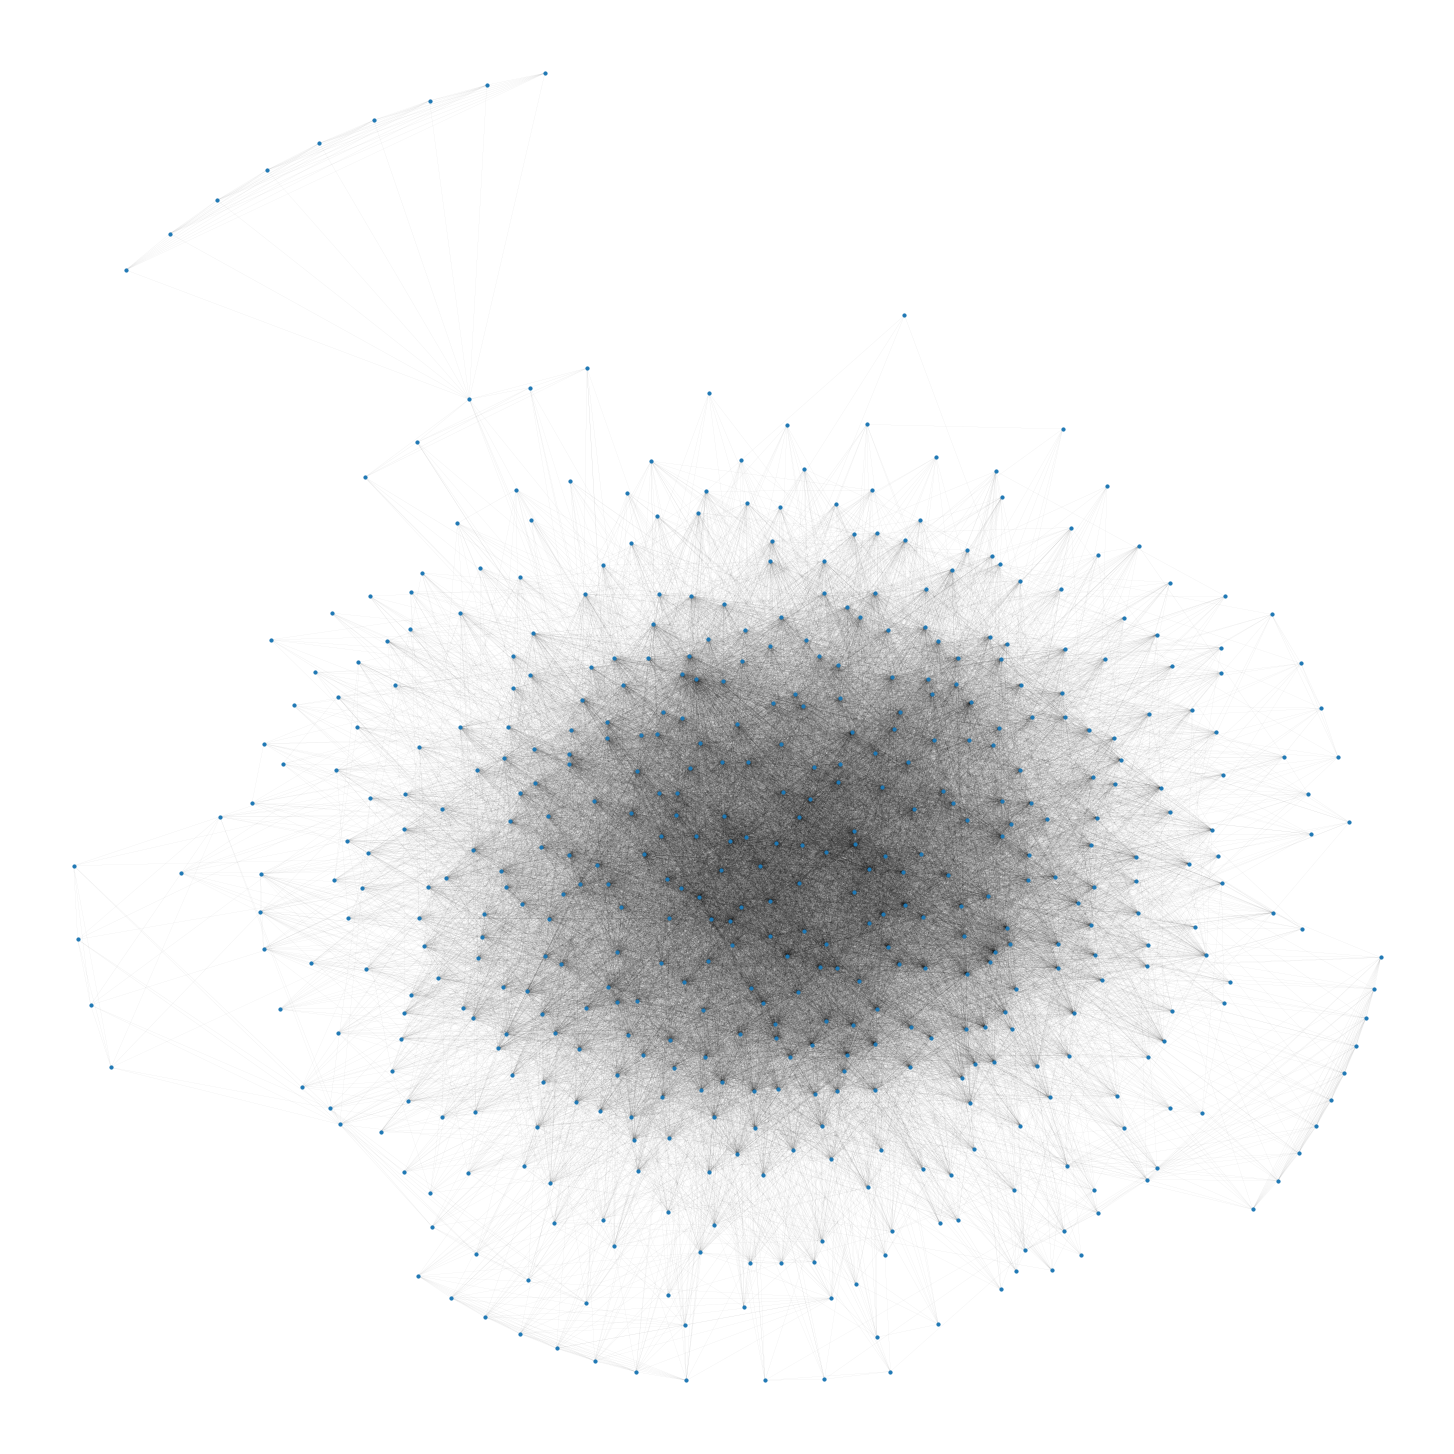

In [31]:
pos = nx.kamada_kawai_layout(video_subgraph)
edge_widths = [w for (*edge, w) in video_subgraph.edges.data('weight')]
plt.figure(figsize=(20,20))
nx.draw(video_subgraph, with_labels=False, node_size=10, width=0.02, pos=pos)
plt.show()